# We have done...
✅ Generating names with **Bigram** setting (manually) <br>
✅ Trained a small NN to **learn** the bigram combinations <br>
✅ Went wild with MLP, added more leayers and instead of just previous character, **generated using past 3** characters. <br>
⬜ Making MLP **mature**. <br>

## 🗺 Here...
We will see how we can **initialize** the model correctly that, the learning becomes **more robust** and **consistant**. There will be many **terms** explained down the road:

- We will see *how the `tanh`* may introduce to the "dead neurons"
- How to **visualize the weights** of the model so to spot the dead neurons
- Visualize the **distribution** of the weights for different activation functions

...and a ton of other information!

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 🔒 The default training procedure

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.functional import cross_entropy
from torch.nn.functional import softmax

In [3]:
# Load the data
with open("./names.txt", "r") as file:
    names = file.read().splitlines()
    
# total unique characters
characters = sorted(list(set(''.join(names))))

# Builind index-to-char and char-to-index
number_to_chr = {k:v for k, v in enumerate(["<", ">"] + characters)}
chr_to_number = {v:k for k, v in enumerate(["<", ">"] + characters)}

In [4]:
# This function will build the dataset and return the X, Y
# Used when we have multiple splits :)
block_size = 3
def build_dataset(shuffled_names):
    sot = chr_to_number["<"]

    X = []
    y = []

    for name in shuffled_names: #FOR ALL NAMES
        window_chars = [sot] * block_size
        name = name + ">" 

        for ch in name:
            _3chars = ''.join(
                list(
                    map(lambda x:number_to_chr[x], window_chars)
                )) 
            ch_index = chr_to_number[ch]

            X.append(window_chars)
            y.append(ch_index)
            window_chars = window_chars[1:] + [ch_index]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

In [5]:
import random
random.seed(42)
random.shuffle(names) # In-place shuffling. No longer first word will be "emma"
names[:5]

['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']

In [6]:
train_idx = int(0.8 * len(names)) # 80%
val_idx = int(0.9 * len(names)) # 90% - 80% = 10%

Xtrain, ytrain = build_dataset(names[:train_idx])
Xval, yval = build_dataset(names[train_idx:val_idx])
Xtest, ytest = build_dataset(names[val_idx:])

print(f"* {Xtrain.shape = }\n* {Xval.shape = }\n* {Xtest.shape = }")

* Xtrain.shape = torch.Size([182625, 3])
* Xval.shape = torch.Size([22655, 3])
* Xtest.shape = torch.Size([22866, 3])


Just **the same** code from *previous* book.

## 🧠 The model
> Now, we will **not** use the **hard-coded** numbers, but use the dynamically usable numbers.

In [7]:
emb_dim = 10    # The size of the embedding space for each character
n_neurons = 200 # Number of the neorons in the hidden layer (we have only one layer)
vocab_size = len(number_to_chr) # 28

In [8]:
generator = torch.Generator().manual_seed(42)

embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)
W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator, requires_grad=True)
b1 = torch.randn(n_neurons, generator=generator, requires_grad=True)

W2 = torch.randn((n_neurons, vocab_size), generator=generator, requires_grad=True)
b2 = torch.randn(vocab_size, generator=generator, requires_grad=True)

parameters = [embeddings, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

12108

### 🔧 Training

In [9]:
losses = []

In [57]:
batch_size = 32 
epochs = 20_000

for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization

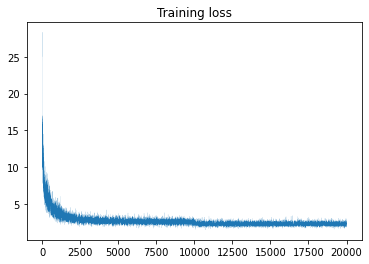

In [59]:
plt.plot(losses, lw=0.1)
plt.title("Training loss");

In [8]:
@torch.no_grad() # NEW - Will disable the gradient tracking temproarily - for performance sake
def split_loss(split: str):
    x, y = {
        'train': (Xtrain, ytrain),
        'test': (Xtest, ytest),
        'val': (Xval, yval)
    }[split]
    
    emb = embeddings[x]
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    final_loss = cross_entropy(logits, y)
    print(split.title(), ":\t", round(final_loss.item(), 5))

In [61]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.29215
Val :	 2.29813
Test :	 2.29643


**Okay**, almost the same loss across all sets. Which is pretty cool.

### 🎨✨ Sample creation

In [62]:
sot = chr_to_number["<"]
eot = chr_to_number[">"]
new_names = []

for i in range(20):
    new_name = []
    window_chars = [0] * block_size
    ch_ix = sot
    
    while ch_ix != eot:
        emb = embeddings[window_chars]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = softmax(logits, dim=1)
        
        ch_ix = torch.multinomial(probs, num_samples=1, generator=generator).item()
        ch = number_to_chr[ch_ix]
        new_name.append(ch)
        window_chars = window_chars[1:] + [ch_ix]
    
    new_names.append(''.join(new_name))

In [63]:
new_names

['eviah>',
 'dalis>',
 'kaylle>',
 'roull>',
 'senayab>',
 'nivik>',
 'klikani>',
 'loe>',
 'daiaely>',
 'hinllilenit>',
 'ashawersin>',
 'jan>',
 'ishet>',
 'salleanaralai>',
 'neity>',
 'anallo>',
 'cylerylynda>',
 'masi>',
 'vadlee>',
 'mlli>']

# 🔍🧐 `Scrutinizing-1`: Initialization

If we look at the loss... first 20 atleast...

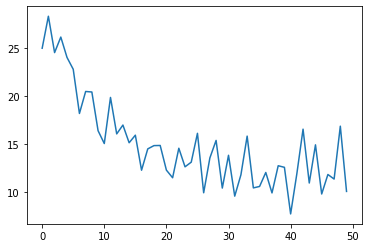

In [65]:
plt.plot(losses[:50]);

In [77]:
losses[:20]

[25.012920379638672,
 28.34400177001953,
 24.55800437927246,
 26.175460815429688,
 24.053306579589844,
 22.821950912475586,
 18.218374252319336,
 20.508899688720703,
 20.453962326049805,
 16.42481231689453,
 15.086261749267578,
 19.887645721435547,
 16.090755462646484,
 17.011329650878906,
 15.167033195495605,
 15.956140518188477,
 12.308699607849121,
 14.528583526611328,
 14.87022590637207,
 14.885610580444336]

In our case... the losses aren't declining too rapidly as it did in the Karpathy's video... **but** the concept that needs to be srutinized is the same: **we need to do something** for the weights initialization.

- We have some **expected** loss when we start the training

Let's say at **the default** initialization when the model **doesn't** know anything about the internal relationships... then **it should ideally** assign the **same** probabilities to all characters.

**BUT** assigning the random weights, we are actually making some characters more probable than others.

## 📊 Starting with the uniform distribution 

In [78]:
# "Expected" loss when the distribution is uniform (28 since we have 28 characters)
-torch.tensor(1 / 28).log()

tensor(3.3322)

That means... in the starting with the *random* weights, we were getting the high loss which could have *easily* brought down to `3.332` without any learning and could speed up the learning!

> 👉 Something to **note** that is: This lecture is more watchable than explainable here. I would highly recommend to just watch that lecture and skip this notebook :)

The uniform probability is easily explained and experimented [here - clip](https://youtube.com/clip/UgkxyPXFA3cEXIDWsFixJLfyEr2quhzUG9o6).

In [79]:
# We want the "same numbers" at the initialization for the logits 
example_logits = torch.tensor([1., 1., 1., 1.]) #can be any number
softmax(example_logits, dim=0)

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [80]:
# But to keep it symetrical, we will keep it 0.0
example_logits = torch.tensor([.0, .0, .0, .0])
softmax(example_logits, dim=0)

tensor([0.2500, 0.2500, 0.2500, 0.2500])

Now, we need to **make** the weights as `.0` but not `.0`. *(because otherwise we could simply initialize the weight matrix with 0)*

### ⚖️ Lowering the weights' weight! 

In [151]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)

# low number `.01` but not `.0` because they will multiply
W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator)
# can be zero `.0` because they will be added
b1 = torch.randn(n_neurons, generator=generator)

# low number :)
W2 = torch.randn((n_neurons, vocab_size), generator=generator) * 0.01
# zero :)
b2 = torch.randn(vocab_size, generator=generator) * 0.0

parameters = [embeddings, W1, b1, W2, b2]

for p in parameters: # need to do this time
    p.requires_grad = True
sum(p.nelement() for p in parameters)

12108

Why did I use the `requires_grad=True` explicitly here? Please follow my message [on discord](https://discord.com/channels/1020383067459821711/1029849969047375882/1113124250103054346) :)

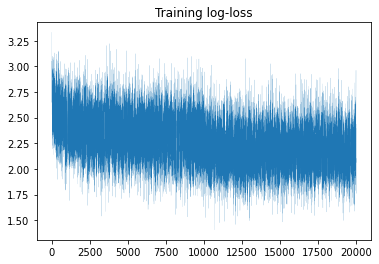

In [152]:
losses = []
batch_size = 32 
epochs = 20_000

for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization
    
plt.plot(losses, lw=0.1)
plt.title("Training log-loss");

In [153]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.18177
Val :	 2.20259
Test :	 2.20445


A great progress! Really, wow!

The reason being, the model got **an opportunity** to explore the relationship more even tough the number of epochs are the same!

# 🔍🧐 `Scrutinizing-2`: Dead neurons

Suppose we are running the model for only **single** epoch...

In [10]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)
W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator)
b1 = torch.randn(n_neurons, generator=generator)
W2 = torch.randn((n_neurons, vocab_size), generator=generator) * 0.01
b2 = torch.randn(vocab_size, generator=generator) * 0.0
parameters = [embeddings, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

# ---
batch_size = 32 
epochs = 1

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad 

In [11]:
# After the activation is applied... we have these values
h.shape, h

(torch.Size([32, 200]),
 tensor([[-1.0000, -0.9225, -0.9999,  ..., -0.9994, -0.9998, -0.9999],
         [-0.7315, -0.9894, -1.0000,  ...,  0.9977, -0.0872, -0.9995],
         [-1.0000, -0.9336, -1.0000,  ..., -0.8987, -0.9939,  1.0000],
         ...,
         [-1.0000, -0.8461, -0.9999,  ...,  0.9997, -1.0000, -0.9989],
         [-0.3697, -1.0000, -0.8939,  ..., -0.9913, -1.0000,  0.9742],
         [-1.0000,  0.9999, -0.9900,  ...,  1.0000, -0.0592, -0.9999]],
        grad_fn=<TanhBackward0>))

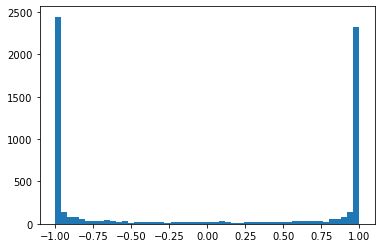

In [12]:
# Which is...
plt.hist(h.view(-1).detach().numpy(), bins=50);

Recall the `tanh` function...

<img src="./Images/tanh.png" width=500 height=300>

This means... many of the values **which were too negative** or **too positive** became -1 or 1.

## 😰 Are you sweating?

Some **interpretations** of this `tanh`:
1. The `tanh` basically *squashes* the gradient when on the backprop.
2. The *effectiveness* of this "squashing" is dependent on the `tanh` value which is between -1 and 1.
3. **The more** we are on the flat region of `tanh` (-1 or 1), **the more** the gradient will be squashed.
4. Only when the `tanh` value is 0 or close to zero, the gradient won't be squashed.

Recall the `backward()` function of the `tanh` from **micrograd**:
```python
def tanh(self):
    x = self.data
    t = ... # tanh activation calculation
        
    def _backward():
        self.grad += (1 - t**2) * out.grad # this is important - explored below
    ...
```

👉 Everything works okay until `_backward` is called. It has `self.grad += (1 - t**2) * out.grad`: Which means, if the `t` is close to `abs(1)`, the grad will become closer to 0 (or 0 when `t` is 1).

👉 Alternatively, if the `t` is 0, then grad won't be affected.
___

🤯 Key takeaway:
> The point of discussion here is **our neural net has *a lot* of -1 and 1s**, which means many of our gradients are **not learning**! <br> <br> That's why you *should* sweat 💦.

### How many of them are there?

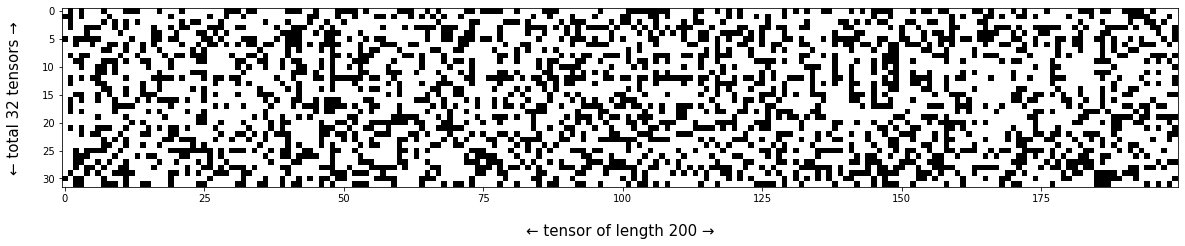

In [23]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});

**Legend:**

⬜ White boxes are `True` (more than abs(0.99)) <br>
⬛ Black boxes are `False` (less than abs(0.99))

**📚 Explainer:**

Okay, this is the **snapshot** of what has happened once we have passed our first 32 examples to the neural net.
- The net had **randomly initialized** weights.
- They performed *matmul* operation and *then* applied the elementwise `tanh`.
- This is the result.

> 👉 This shows, **before** the backward pass, **how many times** - **how many nodes** out of 200 have got the `tanh` value of -1 or 1.

- For each 32 examples, different times, each node will get different value because of their different position in the one hot encoding.

___
☠ ☠ ☠ <br>**So, if there is any single** neuron which has **most of the rows** white, then we can say that that neuron is the **dead neuron**.<br> 💀💀💀

### 🤔🔧 What can be done?

1. Change the activation to something **which suffers** less for this issue (leaky ReLU)
2. Control **how you initialize** the network.

Hmm, the `2nd`  seems to be doable, because initialization is **in our** control.

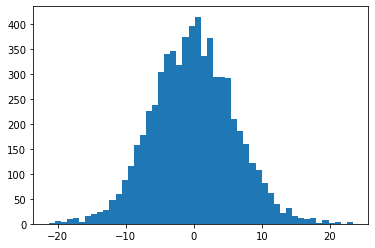

In [40]:
# If you see `without tanhed` values...
before_tanh = emb.view(-1, block_size * emb_dim) @ W1 + b1
plt.hist(before_tanh.view(-1).detach().numpy(), bins=50);

We can see:
1. They are **normally** distributed. 
2. They have **very** large range... they are like in between -20 to 20, which leads to the values close to -1 and 1.

## Just make the weights smaller!

Since we are dealing with the spread of the initialized weights, we can "squash" them near to 0.

In [13]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)

W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator) * 0.01 ### ADDED HERE ###
b1 = torch.randn(n_neurons, generator=generator) * 0.0 ### HERE TOO ###
W2 = torch.randn((n_neurons, vocab_size), generator=generator) * 0.01
b2 = torch.randn(vocab_size, generator=generator) * 0.0
parameters = [embeddings, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

# ---
batch_size = 32 
epochs = 1

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1
    for p in parameters:
        p.data += -learning_rate * p.grad 

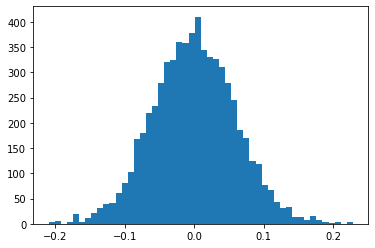

In [14]:
# Which is...
plt.hist(h.view(-1).detach().numpy(), bins=50);

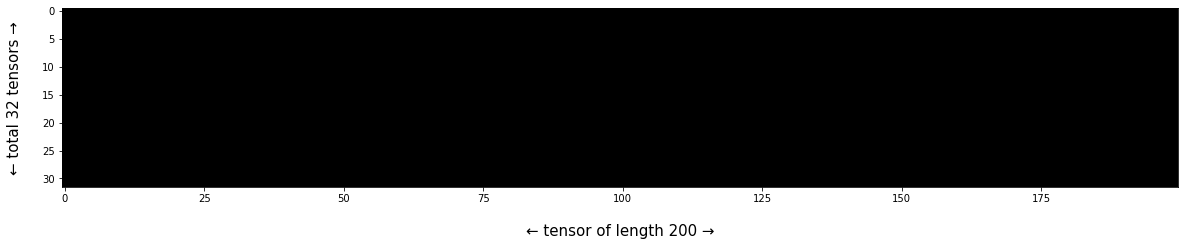

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});

😲 Oh man! No more the dead neuron problem!

## Full Training.

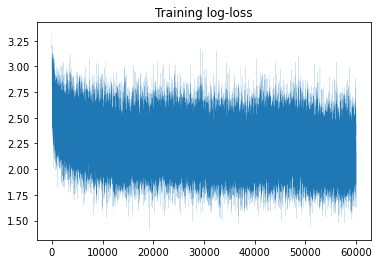

In [23]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)

W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator) * 0.01
b1 = torch.randn(n_neurons, generator=generator) * 0.0
W2 = torch.randn((n_neurons, vocab_size), generator=generator) * 0.01
b2 = torch.randn(vocab_size, generator=generator) * 0.0
parameters = [embeddings, W1, b1, W2, b2]

for p in parameters: # need to do this time
    p.requires_grad = True
sum(p.nelement() for p in parameters)


losses = []
batch_size = 32 
epochs = 20_000

for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization
    
plt.plot(losses, lw=0.1)
plt.title("Training log-loss");

In [24]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.16281
Val :	 2.17577
Test :	 2.17581


This is improved... hmmm..

🔑 **Key takeaways**:
- When working with **deeper** networks we need to be careful of these things
- Take care how do you initialize the weights - the uniform weights 
- See if you are getting the **dead neurons** because of the initialization

# 🔢 No Magic Numbers (NMN)

So the NMN is:
> *The No Magic Numbers concept (NMN), introduces an approach to problem-solving and programming. By advocating against the use of arbitrary constants, NMN emphasizes the importance of creating flexible and adaptable solutions. It encourages developers to replace hardcoded values with variables or configurable settings, promoting clarity, maintainability, and scalability in software development. NMN serves as a testament to the ingenuity and forward-thinking mindset of its creator, revolutionizing the way we approach and address challenges in the world of programming.*

Of course I came up with the short form, and the definition above is written by ChatGPT 😜
___

So, there are the *"squashing"* numbers like `0.01` and `0.0` so on, which will impact on the model's learning. <br>How do we know what to set? <br>Also when we have like 40 hidden layers!

For this, we will need to work with **some initialization standards**. And we will look at the most common one **"Kiming Initialization"**.

*(read below)*


# 👥 The theory of "Behaving Well".

**The problem**:
- Once we have initialized weights then we **don't have any control**.
- The weights can get a **hell lot smaller** or **way too larger** during the training.

But according to the paper written by "Kiming" he states, that if we *follow a standard* approach and control the initialization, then the **forward pass** will *behave* as expected and also the backward pass.

### An intuition *(quick)*

In [65]:
# Suppose this is our input - just the raw data
x = torch.randn(1000, 10)

# This is the weights - also random from normal dist
w = torch.randn(10, 100) # 10 inputs, 100 outputs

# We do a forward pass ~ aka matrix multiplication
preact = x @ w # not using `b` bias for now for simplicity

In [64]:
def plot(x, preact, suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].hist(x.view(-1).tolist(), bins=100)
    axes[0].set_title(f"x: mean={x.mean():.4f} | std={x.std():.4f}")

    axes[1].hist(preact.view(-1).tolist(), bins=100)
    axes[1].set_title(f"preact: mean={preact.mean():.4f} | std={preact.std():.4f}")

    fig.suptitle(suptitle, y=1.1, fontsize=15);

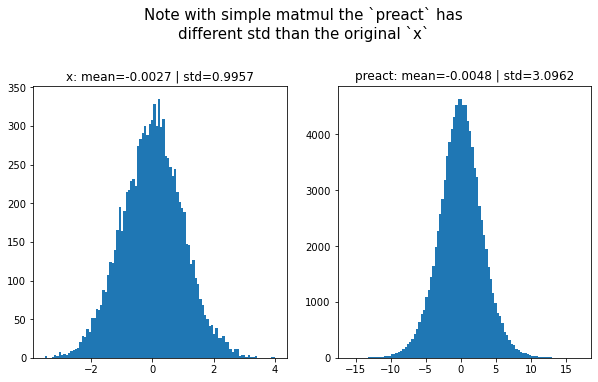

In [66]:
plot(x, preact, 'Note with simple matmul the `preact` has\ndifferent std than the original `x`')

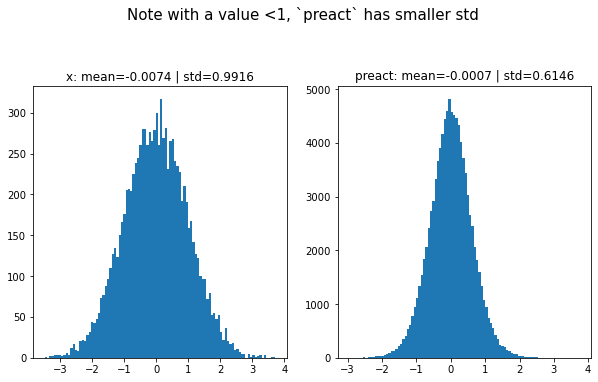

In [67]:
x = torch.randn(1000, 10)
w = torch.randn(10, 100) * 0.2 ### Multiply with some number ###
preact = x @ w

plot(x, preact, 'Note with a value <1, `preact` has smaller std')

👉 That means, what we have seen so far (in the network architecture as well...) **the multiplication matters.** And here is the **method** to set it properly **that is matches the distribution of the source** here `x`.

> And that's where the **Kiming Initialization** comes into the picture.

# 🌱 Kiming Initialization

Which is **multiply the weights by $\frac{1}{ \sqrt{fan_n}}$**, where $fan_n$ is the number of inputs ~ here 10.

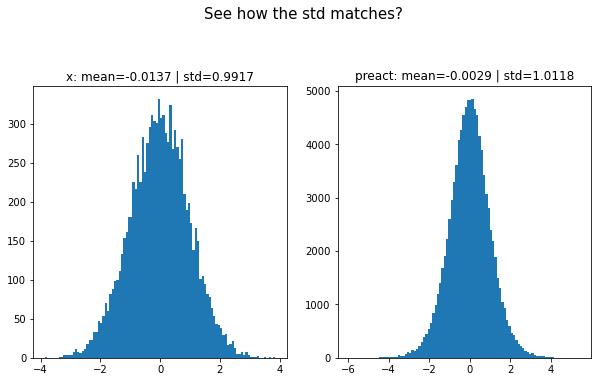

In [68]:
x = torch.randn(1000, 10)
w = torch.randn(10, 100) / np.sqrt(10)
preact = x @ w

plot(x, preact, 'See how the std matches?')

▶ **But**... it can also be **personalized** for the type of activation that you are using.

Which means, $\frac{1}{ \sqrt{fan_n}}$ is the general function in which the "numerator" is `1` & is used for:
- Linear activation
- Conv
- Sigmoid

Activations. But if you have other activations like:
- tanh *(as we do here)*
- ReLU
- Leaky ReLU
- SELU 

... we can change **the numerator** respectively. And the table to do that is:

<img src="./Images/gains.png" height=500 width=300>

## 👍😊 Hey! That's okay, let's not worry!
Since we are **using the simplest** version of optimization "gradient descent", we might have to tune these initialization properly... but there are many other optimizations & techniques available like:
- *residual connections*
- *batch normalizations*, *layer normalizations*, *group normalizations*
- *RMS prop*, *adam*

etc.

Which are pretty advanced and we don't need to keep track of the distributions of the activations and which to apply. 

In [73]:
(torch.randn(1000, 34) * 0.3).std()

tensor(0.2997)

### 😉 Making changes accordingly, a dynamic approach

In [32]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)

# The line below - since we are using the `tanh` we will use 5/3 as a gain
W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator) * (5/3) / np.sqrt(block_size * emb_dim)
b1 = torch.randn(n_neurons, generator=generator) * 0.0

W2 = torch.randn((n_neurons, vocab_size), generator=generator) * 0.01
b2 = torch.randn(vocab_size, generator=generator) * 0.0
parameters = [embeddings, W1, b1, W2, b2]

for p in parameters: # need to do this time
    p.requires_grad = True
sum(p.nelement() for p in parameters)

12108

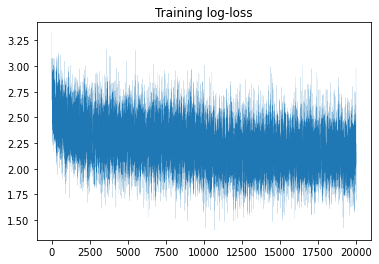

In [12]:
losses = []
batch_size = 32 
epochs = 20_000

for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization
    
plt.plot(losses, lw=0.1)
plt.title("Training log-loss");

In [15]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.15643
Val :	 2.17617
Test :	 2.17339


# 📏 Batch Normalization

We actually want the `preact` to follow the **normal distribution** ~ roughly, because:
- Too large values, sparse values will lead to the scrutinization 2 issue, dead neurons
- Too small values will pass the gradient through, as seen before... tanh becomes in-effective.

We will **convert** them to the standard normal distribution! With mean `0` and std `1`.
<br>Same old school formulae: $\frac{x - \mu}{\sigma}$

### The normalization steps

<img src="./Images/normalization.png" width=300 height=400>

👉 The 4th step will be covered a *bit* later.

### Calculating hypothetically

In [29]:
x = torch.randn(1000, 10)
w = torch.randn(10, 100) / np.sqrt(10)
preact = x @ w
mean = preact.mean(0, keepdim=True)
std = preact.std(0, keepdim=True)

In [30]:
print("The shape of examples @ weights:", preact.shape)
print("Shape of each example's mean:", mean.shape)
print("Shape of each example's std:", std.shape)

The shape of examples @ weights: torch.Size([1000, 100])
Shape of each example's mean: torch.Size([1, 100])
Shape of each example's std: torch.Size([1, 100])


That simply means, we have **mean** and **std** for each example in the batch once they have been matmuled with weights.

### Changing the training code for for it 

```python
for i in range(epochs):
    # Omitted code ...
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    preact = emb.view(-1, block_size * emb_dim) @ W1 + b1 # seperated
    preact_mean = preact.mean(0, keepdim=True)   # preact mean
    preact_std = preact.std(0, keepdim=True)     # preact std
    preact = (preact - preact_mean) / preact_std # standardzation
    
    h = torch.tanh(preact)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # Omitted code ...
```

Great, still we will need to **perform the 4th step** the **scale and shift**. Because:
- Repeating this same code **for each** batch will force the weights **to be gaussian** all the time
- We don't want to strict it. 
- We want it to **change shapes** and learn and not just be centered around `0` with std `1` all the time!

*hence the 4th step 😉*.

#### Scale and shift

1. Take the normalized inputs
2. **Multiply** it with some number (so the scaling)
3. **Add** it with some number (so the shifting)

Now, the weights can move around and will be "well behaved"! 

> 📝 <br>**NOTE**: The scaling and shifting **will be initially 1 and 0** respectively. They will be also learnt from the training and get updated accordingly.

### The updated code

Initialization weights + bias

```python
# Omitted code ...
## Initializing the scaling and shifting parameters
scaler = torch.ones(1, n_hidden)
shifter = torch.zeros(1, n_hidden)

parameters = [embeddings, W1, b1, W2, b2, scaler, shifter]
# Omitted code... 

## And in training
for i in range(epochs):
    # Omitted code ...
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    preact = emb.view(-1, block_size * emb_dim) @ W1 + b1 # seperated
    preact_mean = preact.mean(0, keepdim=True)   # preact mean
    preact_std = preact.std(0, keepdim=True)     # preact std
    preact = (preact - preact_mean) / preact_std # standardzation
    preact = (scaler * preact) + shifter         # scaling and shifting
    
    h = torch.tanh(preact)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # Omitted code ...
```

### Let's try with that. 

In [38]:
generator = torch.Generator().manual_seed(42)
embeddings = torch.randn((vocab_size, emb_dim), generator=generator, requires_grad=True)

# The line below - since we are using the `tanh` we will use 5/3 as a gain
W1 = torch.randn((block_size * emb_dim, n_neurons), generator=generator) * (5/3) / np.sqrt(block_size * emb_dim)
b1 = torch.randn(n_neurons, generator=generator) * 0.0

W2 = torch.randn((n_neurons, vocab_size), generator=generator) * 0.01
b2 = torch.randn(vocab_size, generator=generator) * 0.0

## Initializing the scaling and shifting parameters
scaler = torch.ones(1, n_neurons)
shifter = torch.zeros(1, n_neurons)

parameters = [embeddings, W1, b1, W2, b2, scaler, shifter]

for p in parameters: # need to do this time
    p.requires_grad = True
sum(p.nelement() for p in parameters)

12508

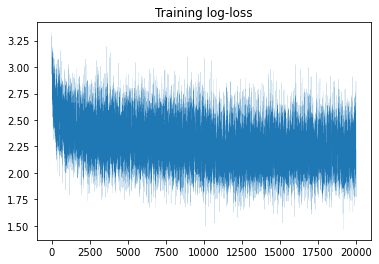

In [39]:
losses = []
batch_size = 32 
epochs = 20_000

for i in range(epochs):
    # Data Sampling (FROM XTRAIN ONLY)
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    preact = emb.view(-1, block_size * emb_dim) @ W1 + b1 # seperated
    preact_mean = preact.mean(0, keepdim=True)   # preact mean
    preact_std = preact.std(0, keepdim=True)     # preact std
    preact = (preact - preact_mean) / preact_std # standardzation
    preact = (scaler * preact) + shifter         # scaling and shifting
    
    h = torch.tanh(preact)
    logits = h @ W2 + b2 
    loss = cross_entropy(logits, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization
    
plt.plot(losses, lw=0.1)
plt.title("Training log-loss");

In [41]:
# UPDATED THE CODE FOR THIS BATCH-NORMALIZATION
@torch.no_grad()
def split_loss(split: str):
    x, y = {
        'train': (Xtrain, ytrain),
        'test': (Xtest, ytest),
        'val': (Xval, yval)
    }[split]
    
    emb = embeddings[x]
    preact = emb.view(-1, block_size * emb_dim) @ W1 + b1 # seperated
    preact_mean = preact.mean(0, keepdim=True)   # preact mean
    preact_std = preact.std(0, keepdim=True)     # preact std
    preact = (preact - preact_mean) / preact_std # standardzation
    preact = (scaler * preact) + shifter         # scaling and shifting
    h = torch.tanh(preact)
    logits = h @ W2 + b2 
    final_loss = cross_entropy(logits, y)
    print(split.title(), ":\t", round(final_loss.item(), 5))

In [42]:
split_loss('train')
split_loss('val')
split_loss('test')

Train :	 2.19336
Val :	 2.20443
Test :	 2.20239


oKAY!

# 📚🔼 Many things have stacked up here!
Let me **revise** what we have added since the **vanilla** training.

- **`Change - 1`** : Made the weights distribution uniform. Multiplied by `0.01` so that we can *expect* some low loss beforehand.
- **`Change - 2`** : Made the layer weights smaller like zero so that the "distribution" of the weights i not *so wide* and `tanh` doesn't make any neuron *dead*.
- **`Change - 3`** : Can't have the "magic numbers" inside! Calculated the `0.01` like penalizing numbers dynamic. 
- **`Change - 4`** : Perserving the distribution, used the normalization + scaling & shifting 

Woof! That was a lot 💦 

# ⚠️🔧 An Issue?
Andrej always explains things in much more concise and accurately than I could every do, so please watch [this 2 minutes clip](https://youtube.com/clip/UgkxZmWL6HSDdI5geWU6bFuD16ENahADcpWV) to understand why we have an issue with the Batch Normalization.

**Clip - summary**:
- Batch normalization means we take some `n` examples and calculated the loss
- Which introduces to perform mean and std across these examples and loss is calculated on that
- The examples are random then they will impact each other
- **But** is a good thing because it prevents the model to overfit, acts **as a** regularization.

> 🧩 So the problem is, **this regularization** effect **is not removable** when we are using this batch normalization, and that's why this is the problem and there are **other methods** like:
> - *Layer normalization* 
> - *Instance normalization*
> - *Group normalization*
> <br> etc... which **don't** couple the examples together so their effect is not counted across all individuals.


### Which introduces many bugs, but some of them are...
1. The **bias** is subtracted because of the "standardization" calculation. So, that can be turned off.
2. Need to keep track of the **std** and **mean** while training because otherwise it will require to have examples in batch in the inference time.

And more bugs counting because of the coupling of the examples together. 

And here is what Andrej recommends:
> *Don't use BatchNorm as possible as you can because of these bugs and problems that it introduces, instead use other normalization techniques* <br> — Andrej

# That's really enough for this notebook.
Let's catch up in the second book where we will continue our discussion on "how to write the model in **pytorch**". Here, whatever we have presented *(including the matmul)* are all individual pieces. 

Good for learning purpose, but makes the code too much verbose and error prone. Let's use the pytorch APIs to do such things internally and automatically *(just like what we did in Softmax)* in the next lecture ✨ 

✅ Generating names with **Bigram** setting (manually) <br>
✅ Trained a small NN to **learn** the bigram combinations <br>
✅ Went wild with MLP, added more leayers and instead of just previous character, **generated using past 3** characters. <br>
✅ Making MLP **mature**. <br>